# Recommender baselines extended tutorial
This tutorial provides a detailed description of a few recommender models which are widely used in both research and industry. All of them are proved to be strong and reliable baselines for many use cases. They are also often chosen as candidate generators followed by neural networks and gradient boosting decision trees for re-ranking of retrieved items. 

With RecTools you can use any of them with a few lines of code in the same interface.

**Table of Contents**

* [Prepare data](#data)
* [Matrix Factorization](#mf)
  * **[iALS](#ials) [Hybrid]**
    * [Model description](#ials_desc) | [Recommendations](#ials_rec) | [RecTools implementation](#ials_impl) | [Model Application](#ials_apply) | [Links](#ials_links)  
  * **[LightFM](#lightfm) [Hybrid] [Hot & Warm & Cold inference] [Logistic / BPR / WARP loss]**
    * [Model description](#lightfm_desc) | [Recommendations](#lightfm_rec) | [RecTools implementation](#lightfm_impl) | [Model Application](#lightfm_apply) | [Links](#lightfm_links) 
  * **[PureSVD](#svd)**
    * [Model description](#svd_desc) | [Recommendations](#svd_rec) | [RecTools implementation](#svd_impl) | [Model Application](#svd_apply) | [Links](#svd_links) 
* [Nearest Neighbours](#nn)
    * **[ItemKNN](#itemknn)**
        * [Model description](#itemknn_desc) | [Recommendations](#itemknn_rec) | [RecTools implementation](#itemknn_impl) | [Model Application](#itemknn_apply) | [Links](#itemknn_links) 
* [Linear Autoencoders](#la)
    * **[EASE](#ease)**
        * [Model description](#ease_desc) | [Recommendations](#ease_rec) | [Model Application](#ease_apply) | [Links](#ease_links) 

In [1]:
import numpy as np
import pandas as pd
import warnings
from pathlib import Path
import os
import threadpoolctl

warnings.filterwarnings('ignore')

from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import CosineRecommender

# lightfm extension is required for the LighFM section. You can install it with `pip install rectools[lightfm]`
try:
    from lightfm import LightFM
except ModuleNotFoundError:
    pass

from rectools import Columns
from rectools.dataset import Dataset
from rectools.models import ImplicitALSWrapperModel, LightFMWrapperModel, PureSVDModel, ImplicitItemKNNWrapperModel, EASEModel

# For implicit ALS
os.environ["OPENBLAS_NUM_THREADS"] = "1"
threadpoolctl.threadpool_limits(1, "blas");

# Prepare data <a class="anchor" id="data"></a>
We are using [KION](https://github.com/irsafilo/KION_DATASET) dataset for this tutorial. The data was gathered from the users of MTS KION video streaming platform and includes user-item interactions together with user and item features

In [2]:
%%time
!wget -q https://github.com/irsafilo/KION_DATASET/raw/f69775be31fa5779907cf0a92ddedb70037fb5ae/data_en.zip -O data_en.zip
!unzip -o data_en.zip
!rm data_en.zip

Archive:  data_en.zip
  inflating: data_en/items_en.csv    
  inflating: __MACOSX/data_en/._items_en.csv  
  inflating: data_en/interactions.csv  
  inflating: __MACOSX/data_en/._interactions.csv  
  inflating: data_en/users_en.csv    
  inflating: __MACOSX/data_en/._users_en.csv  
CPU times: user 286 ms, sys: 122 ms, total: 408 ms
Wall time: 16.1 s


In [3]:
# Read data
DATA_PATH = Path("data_en")
users = pd.read_csv(DATA_PATH / 'users_en.csv', index_col=0)
print(users.shape)
users.head(2)

(840197, 5)


,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,M,1
1,962099,age_18_24,income_20_40,M,0


In [4]:
items = pd.read_csv(DATA_PATH / 'items_en.csv', index_col=0)
print(items.shape)
items.head(2)

(15963, 16)


,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,description,keywords,actors_translated,actors_transliterated,directors_translated,transliterated
0,10711,film,Talk to her,Hable con ella,2002.0,"drama, foreign, detective, melodrama",Spain,NaN,16.0,NaN,"Marco, a journalist, interviews the famous Tor...","Talk, her, 2002, Spain, friends, love, strong,...","Adolfo Fernández, Ana Fernández, Dario Grandin...","Adol'fo Fernandes, Ana Fernandes, Dario Grandi...",Pedro Almodovar,Pedro Al'modovar
1,2508,film,Naked Peppers,Search Party,2014.0,"foreign, adventure, comedy",USA,NaN,16.0,NaN,The main character has learned not to invite h...,"Naked, Peppers, 2014, USA, friends, weddings, ...","Adam Palley, Brian Huskey, JB Smoove, Jason Ma...","Adam Palli, Brajan Haski, Dzh.B. Smuv, Dzhejso...",Scott Armstrong,Skot Armstrong


In [5]:
interactions = (
    pd.read_csv(DATA_PATH / 'interactions.csv', parse_dates=["last_watch_dt"])
    .rename(columns={"last_watch_dt": Columns.Datetime})
)
print(interactions.shape)
interactions.head(2)

(5476251, 5)


,user_id,item_id,datetime,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0


In [6]:
# Process interactions
interactions[Columns.Weight] = np.where(interactions['watched_pct'] > 10, 3, 1)
interactions = interactions[["user_id", "item_id", "datetime", "weight"]]
print(interactions.shape)
interactions.head(2)

(5476251, 4)


,user_id,item_id,datetime,weight
0,176549,9506,2021-05-11,3
1,699317,1659,2021-05-29,3


In [7]:
# Process user features to the form of a flatten dataframe
users = users[["user_id", "age", "sex"]]
users.fillna('Unknown', inplace=True)
user_features_frames = []
for feature in ["sex", "age"]:
    feature_frame = users.reindex(columns=[Columns.User, feature])
    feature_frame.columns = ["id", "value"]
    feature_frame["feature"] = feature
    user_features_frames.append(feature_frame)
user_features = pd.concat(user_features_frames)
print(user_features.shape)
user_features.head(2)

(1680394, 3)


,id,value,feature
0,973171,M,sex
1,962099,M,sex


In [8]:
# Process item features to the form of a flatten dataframe
items = items.loc[items[Columns.Item].isin(interactions[Columns.Item])].copy()
items["genre"] = items["genres"].str.lower().str.replace(", ", ",", regex=False).str.split(",")
genre_feature = items[["item_id", "genre"]].explode("genre")
genre_feature.columns = ["id", "value"]
genre_feature["feature"] = "genre"
item_features = genre_feature
print(item_features.shape)
item_features.head(2)

(39942, 3)


,id,value,feature
0,10711,drama,genre
0,10711,foreign,genre


In [9]:
# Prepare hot test users
test_hot_users = [176549]  # have interactions and features
print(interactions[interactions["user_id"] == test_hot_users[0]].shape)
interactions[interactions["user_id"] == test_hot_users[0]].head(2)

(82, 4)


,user_id,item_id,datetime,weight
0,176549,9506,2021-05-11,3
3815,176549,15469,2021-05-25,3


In [10]:
print(user_features[user_features["id"] == test_hot_users[0]].shape)
user_features[user_features["id"] == test_hot_users[0]]

(2, 3)


,id,value,feature
48323,176549,M,sex
48323,176549,age_35_44,age


In [11]:
# Prepare warm test users
test_warm_users = [1097541]  # have features but don't have interactions
interactions[interactions["user_id"] == test_warm_users[0]].shape

(0, 4)

In [12]:
print(user_features[user_features["id"] == test_warm_users[0]].shape)
user_features[user_features["id"] == test_warm_users[0]]

(2, 3)


,id,value,feature
290301,1097541,F,sex
290301,1097541,age_35_44,age


In [13]:
# Prepare cold test users
test_cold_users = [99999999]  # don't have features or interactions
interactions[interactions["user_id"] == test_cold_users[0]].shape

(0, 4)

In [14]:
user_features[user_features["id"] == test_cold_users[0]].shape

(0, 3)

In [15]:
# Create dataset with both user and item features
dataset = Dataset.construct(
    interactions_df=interactions,
    user_features_df=user_features,
    cat_user_features=["sex", "age"],
    item_features_df=item_features,
    cat_item_features=["genre"],
)

RANDOM_STATE=60

# Matrix Factorization <a class="anchor" id="mf"></a>
The basic idea behind Matrix Factorization is to discover user and item embeddings in a common latent space so that the product of two matrices would reconstruct the original user-item interactions matrix as close as possible. The goal is to predict the missing values in the original matrix and use revealed scores for recommendations.

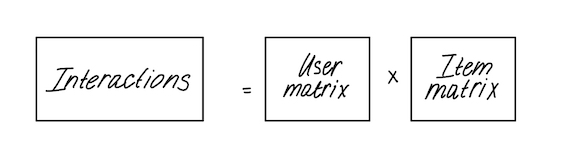

## Implicit ALS <a class="anchor" id="ials"></a>

### Model description <a class="anchor" id="ials_desc"></a>
Goal of the model is to present interactions matrix as a product of user(X) and item(Y) embeddings. Implicit ALS model treats all non-zero entries in the matrix as value `1`. The actual weight of the interactions is treated as `confidence` in the observation. Zero entries receive low confidence since this they are treated as missing values and might actually hide items highly relevant to users. Non-zero entries with high confidence will have greater impact on the loss when not predicted correctly. Overall loss functions is the following:
$$ min_{x*, y*}{ \sum_{u, i}^{}c_{ui}(p_{ui}-x_{u}^Ty_{i})^2 +\lambda (\sum_{u}\lVert x_{u} \rVert ^2 + \sum_{i}\lVert y_{i} \rVert ^2)}$$
$c_{ui}$ - confidence in observing the item (${c_{ui} = 1 + \alpha r_{ui}}$)

* $r_{ui}$ - weight assigned to interaction of user u with item i
* $\alpha$ - rate of increase in confidence. Determines to what extent change in weight modifies confidence
  
$p_{ui}$ - <b>binary</b> representation, whether user and item had interaction \
$x_{u}$, $y_{i}$ - vectors we need to find for users and items \
$\lambda$ - regularization term to avoid overfitting 

Since both X and Y matrices have to be calculated, an alternating least squares algorithm is used. The procedure is done by repeatadly performing following 2 steps:

1. Fix X (user matrix) and find optimal Y (item matrix)

2. Fix Y (item matrix) and find optimal X (usermatrix)

This algorithm simplifies calculations, as when one of the matrices is fixed, the cost function becomes quadratic and has an easily achievable minimum. After the algorithm has converged, values of X and Y are taken as embeddings.

### Recommendations <a class="anchor" id="ials_rec"></a>
Recommendations for all users are received from multiplication of $X^T$ and $Y$, after that top-k can be extracted from $\hat{p} = X^T Y$. As an example consider recommendation procedure for one user, when item and user embeddings are received:

1. Calculate predicted preferences $\hat{p}_{u} = x_{u}^Ty$ (first row of $\hat{p}$ in the picture). It contains information about how likely first user is to be interested in all items
   
2. Take top K items with the greatest value of  $\hat{p}_{ui}$. In the picture if K=1, first item should be recommended, as 8 > 3 and 8 > 7.4

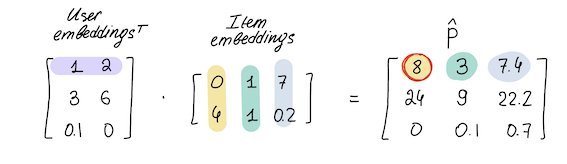

### RecTools implementation <a class="anchor" id="ials_impl"></a>
RecTools provides a wrapper for implicit library iALS implementation which is the most efficient and widely used: `implicit.als.AlternatingLeastSquares` model.  Additionally, RecTools offers a modification, which allows to add explicit user and item features to the model. 

For items it is done in 2 steps (for user explicit features procedure is similar): 

1. Explicit item features are added as additional columns to item embeddings

2. Same number of columns is added to user embeddings (paired to explicit item features)

If both user and item explicit features are used, each embedding matrix contains three logical parts: latent factors, explicit features and paired features. Explicit features will remain their original values after training. Paired features can either be fit together with latent features or separately, this is a hyper-parameter for the wrapper.

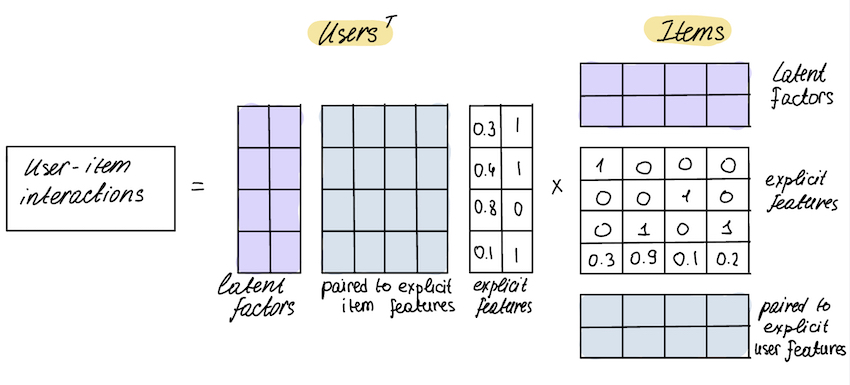

### Model application <a class="anchor" id="ials_apply"></a>
* Specify latent embeddings size with AlternatingLeastSquares `factors`
* Specify `regularization`
* Specify `iterations` for number of model training epochs
* Specify alpha for confidence computation with `AlternatingLeastSquares` `alpha`. Interactions weights that were already present in the dataset will be multiplied by this number. Remember from above that $c_{ui} = 1 + \alpha r_{ui}$ and interactions weights are treated as confidence in observations
* Pass `AlternatingLeastSquares` model to the wrapper
* Specify a way to fit paired features with `ImplicitALSWrapperModel` `fit_features_together`
* Use dataset with features for `fit` and `recommend` to add feature processing to the model

In [16]:
%%time
model = ImplicitALSWrapperModel(
    AlternatingLeastSquares(
        factors=10,  # latent embeddings size
        regularization=0.1, 
        iterations=10,
        alpha=50,  # confidence multiplier for non-zero entries in interactions
        random_state=RANDOM_STATE,
    ),
    fit_features_together=False,  # way to fit paired features
)
model.fit(dataset);

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 27.3 s, sys: 326 ms, total: 27.6 s
Wall time: 27.6 s


In [17]:
recos = model.recommend(
    users=test_hot_users,
    dataset=dataset,
    k=3,
    filter_viewed=True,
)
recos.merge(items[["item_id", "title_orig"]], on="item_id")

,user_id,item_id,score,rank,title_orig
0,176549,7793,2.856475,1,Radioflash
1,176549,16361,2.820227,2,Doom: Annihilation
2,176549,14025,2.778898,3,We Die Young


Vectors from trained model include all of the latent, explicit and paired factors. Vector size is `factors` + (number of explicit user features) + (number of explicit item features)

In [18]:
user_vectors, item_vectors = model.get_vectors()
print(user_vectors.shape)
print(item_vectors.shape)

(962179, 176)
(15706, 176)


### Links <a class="anchor" id="ials_links"></a>
1. iALS original paper: [Collaborative Filtering for Implicit Feedback Datasets](https://www.researchgate.net/publication/220765111_Collaborative_Filtering_for_Implicit_Feedback_Datasets)
2. Optimization for iALS training: [Applications of the Conjugate Gradient Method for Implicit Feedback Collaborative Filtering](https://www.semanticscholar.org/paper/Applications-of-the-conjugate-gradient-method-for-Tak%C3%A1cs-Pil%C3%A1szy/bfdf7af6cf7fd7bb5e6b6db5bbd91be11597eaf0)
3. implicit library iALS  model [documentation](https://benfred.github.io/implicit/api/models/gpu/als.html)
4. **Proving iALS quality**: [Revisiting the Performance of iALS on Item Recommendation Benchmarks](https://arxiv.org/abs/2110.14037)
5. **Proving iALS with features quality**: [Benchmark quality: RecTools wrapper for iALS with features](https://github.com/MobileTeleSystems/RecTools/blob/main/examples/5_benchmark_iALS_with_features.ipynb)

## LightFM <a class="anchor" id="lightfm"></a>

### Model description <a class="anchor" id="lightfm_desc"></a>

LightFM is a python library with an equally named model that has a few special features to add to a classic Matrix Factorization task. It is widely used in both industry and RecSys challenges. Key features are:

1. LightFM introduces biases to both users and items in addition to their latent representations.

2. LightFM is a hybrid matrix factorization model, which aims to include user and item metadata into matrix factorization procedure. To incorporate it LightFm estimates an embedding for each feature and uses a linear combination of feature embeddings to find user/item latent representation.

3. As a result, LightFM provides a solution for building recommendations in warm and cold start scenarios. It utilises item biases and user features embeddings for this task.

4. When building a model, LightFM provides a few loss functions to choose from:
- **Logistic**
- **BPR** (Bayesian Personalized Ranking). Building a LightFM model with BPR loss with no features will result in a widely used BPR-MF model with one extra feature: users and items also have biases
- **WARP** (Weighted Approximate-Rank Pairwise) and k-OS WARP. These are usually the best performing choices for the top-K recommendation task.
  


To incorporate user metadata, user latent representation is derived:

1. Concat user identity matrix with user features (matrix A)
   
2. Take matrix of user factors with prespecified n_factors (matrix B)
   
3. Compute $A\cdot B$. Each row in this matrix is a latent representation for one user

To find item latent representations similar procedure should be performed.




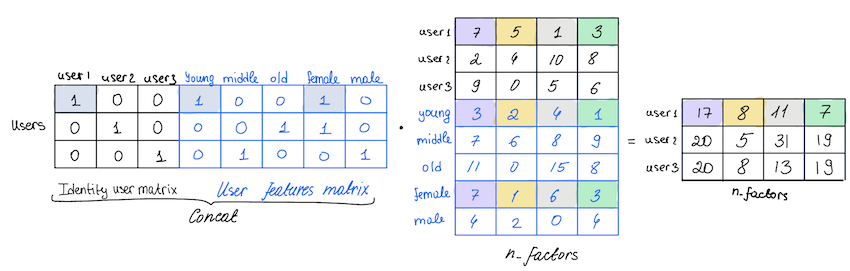

LightFM with **logistic** loss maximizes likelihood of receiving interactions matrix. Zero entries are considered as negatives, non-zero entries are considered positives.
$$ L(e^U, e^I, b^U, b^I) = \prod_{(u,i)\in S^{+}} \hat p_{ui} \times \prod_{(u,i)\in S^{-}}(1 - \hat p_{ui}) $$

$\hat p_{ui} = f(x_{u}\cdot y_{i} + b_{u} + b_{i})$, where f is sigmoid function, as <b>binary</b> prediction is made \
$x_{u} = \sum_{j\in f_{u}} e_{j}^{U}$, $y_{i} = \sum_{j\in f_{i}} e_{j}^{I}$ - latent representations of user and item with $e_{j}^{U}$ and $e_{j}^{I}$ as feature embeddings \
$b_{u} = \sum_{j\in f_{u}} b_{j}^{U}$, $b_{i} = \sum_{j\in f_{i}} b_{j}^{I}$ - bias term for users and items. $b_{j}^{U}$ and $b_{j}^{I}$ are scalar biases \
$S^{+}$ and $S^{-}$ are observed and not observed interactions, respectively 

**BPR** is a pairwise loss, which maximizes the difference between positive and random negative examples. In LightFM it is useful for cases with only positive interactions present and when the goal is to maximize ROC AUC. It is derived from a Bayesian formulation of the problem by finding maximum posterior from likelihood and normal prior. Resulting formula in general case is the following:
$$ \sum_{(u,i,j) \in D_s} ln \sigma (\hat{p}_{uij}) - \lambda_{\theta} \lVert \theta \rVert ^2$$

$D_s := \{(u,i,g)| i \in I_{u}^+ \wedge j \in I \backslash I_{u}^+\}$, set containing triplets of user, positive and negative example \
$\hat{p}_{uij}$ - a function describing relationship between user and 2 items \
$\theta$ - parameters to find

For LightFM framework formula can be rewritten taking into account that: 

1. $\hat{p}_{uij} = \hat{p}_{ui} - \hat{p}_{uj} = x_uy_i + b_u + b_i - x_uy_j - b_u - b_j = x_u(y_i - y_j) + (b_i - b_j)$
   
2. $\Theta = (e^U, e^I, b^U, b^I)$
   
3. LightFM has 2 regularization parameters, which is applied both to embeddings and biases: $\lambda_{item}$ - for items and $\lambda_{user}$ - for users. 
 
Thus, formula is:
$$ \sum_{(u,i,j) \in D_s} ln \sigma (x_u(y_i - y_j) + (b_i - b_j)) - \lambda_{user}( \lVert e^U \rVert ^2 +  \lVert b^U \rVert ^2) - \lambda_{item} (\lVert e^I \rVert ^2 + \lVert b^I \rVert ^2)$$ 

**WARP**, unlike BPR, takes a non-random negative example, which is chosen by comparing scoring predictions. In case prediction for negative example is greater than for positive, negative is taken for optimisation. Gradient update is proportional to number of examples sampled before appropriate one is found, as it reflects how many samples are ranked incorrectly. Such an approach results in better ranking, thus, it is useful when precision@k should be maximized and only positive interactions are present.

Model is trained using asynchronous stochastic gradient descent. Weights of the interactions define how much each observation affects the loss.

### Recommendations <a class="anchor" id="lightfm_rec"></a>
1. For hot user that already had interactions during training scores are computed from user and item latent representations and biases: $score = x_{u}\cdot y_{i} + b_u + b_i$

2. In the warm start scenario the user has <b>no</b> interactions, but user features are known. In this case user representation is taken from user features embeddings and then score is computed: $score = x_{u}\cdot y_{i} + b_i$  

3. In the cold start scenario the user has <b>no</b> interactions and <b>no</b> user features are known. In this case model recommends popular items, basing on biases only $score = b_i$

Top k items with highest scores for each user are taken as recommendations. Sigmoid function can be skipped during recommendations for faster inference

### RecTools implementation <a class="anchor" id="lightfm_impl"></a>
RecTools provides a wrapper for the LightFM model and additionally:
- offers **10-25 times faster** inference
- provides recommendations for hot, cold and warm users in the same interface out of the box

### Model application <a class="anchor" id="lightfm_apply"></a>

`lightfm` extension for rectools is required to run this code. You can install it with `pip install rectools[lightfm]`  
* Select `loss` from "logistic", "warp", "bpr", "warp-kos". "logistic" is default but it usually has the worst performance
* Specify embeddings size with LightFM `no_components`
* Specify l2 regularization penalty on features with LightFM `item_alpha` and `user_alpha`
* Specify other LightFM params
* Pass `LightFM` model to the wrapper
* Specify `epochs` for number of model training epochs
* Use dataset with features for `fit` and `recommend` to add feature embeddings to the model 

In [19]:
%%time
model = LightFMWrapperModel(LightFM(no_components=10, loss="bpr", random_state=RANDOM_STATE))
model.fit(dataset);

CPU times: user 6.28 s, sys: 53.8 ms, total: 6.33 s
Wall time: 6.33 s


Recommend for any type of users (hot / warm / cold) with just passing the necessary ids to `recommend`

In [20]:
recos = model.recommend(
    users=test_hot_users + test_warm_users + test_cold_users,
    dataset=dataset,
    k=3,
    filter_viewed=True,
)
recos.merge(items[["item_id", "title_orig"]], on="item_id").sort_values(["user_id", "rank"])

,user_id,item_id,score,rank,title_orig
0,176549,15861,-220.293716,1,The Dark Tower
1,176549,14361,-220.354294,2,Legion
2,176549,7797,-220.420486,3,Daikaijû kettô: Gamera tai Barugon
3,1097541,15297,-221.292953,1,Klinika schast'ya
5,1097541,3734,-221.551758,2,Prababushka lyogkogo povedeniya
6,1097541,10440,-221.598358,3,Khrustal'nyy
4,99999999,15297,1.297418,1,Klinika schast'ya
7,99999999,10440,1.273827,2,Khrustal'nyy
8,99999999,2657,0.924446,3,Podslushano


Vectors from model include user biases, item biases and embeddings. Vector size is `no_components` + 2

In [21]:
user_vectors, item_vectors = model.get_vectors(dataset)  # pass dataset to process features
print(user_vectors.shape)  # these include all users with features (hot + warm)
print(item_vectors.shape)

(1058088, 12)
(15706, 12)


In [22]:
# user bias is the first value, constant `1`` is the second value (for item biases multiplication)
user_vectors[0]

array([-2.23379684e+02,  1.00000000e+00,  5.62264979e-01, -1.28065735e-01,
       -4.61941302e-01, -1.90039784e-01, -8.23755711e-02, -9.92318988e-02,
        2.55903333e-01, -1.77466646e-02, -4.70214367e-01,  3.65182817e-01])

In [23]:
# constant `1`` is the first value (for user biases multiplication), item bias is the second values
item_vectors[0]

array([ 1.        , -0.2681751 ,  0.3677758 ,  2.59228992, -1.3499459 ,
       -2.1741879 ,  0.18057333, -3.33403778,  0.66558087, -0.87214583,
       -1.09833658, -1.58371723])

### Links <a class="anchor" id="lightfm_links"></a>
1. LightFM original paper: [Metadata Embeddings for User and Item Cold-start Recommendations](https://arxiv.org/abs/1507.08439)
2. LightFM [documentation](https://making.lyst.com/lightfm/docs/home.html)
3. BPR Loss original paper: [BPR: Bayesian Personalized Ranking from Implicit Feedback](https://arxiv.org/abs/1205.2618)
4. LightFM explanation on WARP and K-os WARP loss: [Learning-to-rank using the WARP loss](https://making.lyst.com/lightfm/docs/examples/warp_loss.html)
5. [Benchmark inference speed: RecTools wrapper for LightFM](https://github.com/MobileTeleSystems/RecTools/blob/main/examples/6_benchmark_lightfm_inference.ipynb)

## PureSVD <a class="anchor" id="svd"></a>

### Model description <a class="anchor" id="svd_desc"></a>
Singular value decompozition (SVD) proposes the best approximation of Interactions matrix with respect to least squares error. PureSVD model does not include any regularization and it cannot assign weights to observations. Instead the model tries to reconstruct all of the values in the matrix as close as possible including zero-entries.  This approach is usually not the best one for implicit feedback datasets but it was a very important step in recommender models evolution.  
Model aims to factorize interactions matrix into 3 matrices $U$, $\Sigma$ and $V$, as shown in the picture below. $U$ and $V$ matrices are orthonormal and $\Sigma$ is diagonal with square roots of Interactions eigenvalues on the diagonal.

### RecTools implementation <a class="anchor" id="svd_impl"></a>

RecTools implements a truncated version of SVD. For that k factors should be extracted, meaning that k greatest singular values are taken from $\Sigma$ and k first columns from U and V.


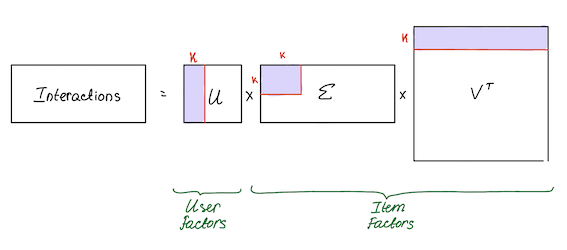

Latent representations of users and items are the following:

1. user factors $X$ = $U$
   
2. item factors $Y$ = $\Sigma \cdot V^{T}$


RecTools uses scipy implementation of scipy.sparse.linalg.svds function to compute decomposition.

### Recommendations <a class="anchor" id="svd_rec"></a>
1. Recommendation for user/item pair is the following: $\hat{r_{ui}} = x_u y_i$

2. Take k items with greatest $\hat{r_{ui}}$ for fixed user

### Model application <a class="anchor" id="svd_apply"></a>
* Specify embedding size with PureSVDModel `factors`
* If we use dataset with features for `fit` and `recommend`, model just skips this info

In [24]:
%%time
model = PureSVDModel(factors=10)
model.fit(dataset);

CPU times: user 681 ms, sys: 19.7 ms, total: 700 ms
Wall time: 699 ms


In [25]:
recos = model.recommend(
    users=test_hot_users,
    dataset=dataset,
    k=3,
    filter_viewed=True,
)
recos.merge(items[["item_id", "title_orig"]], on="item_id")

,user_id,item_id,score,rank,title_orig
0,176549,7571,1.893236,1,100% Wolf
1,176549,12173,1.524853,2,Avengers: Endgame
2,176549,10942,0.996734,3,MARVEL'S THE AVENGERS


In [26]:
user_vectors, item_vectors = model.get_vectors()
print(user_vectors.shape)
print(item_vectors.shape)

(962179, 10)
(15706, 10)


### Links <a class="anchor" id="svd_links"></a>
1. PureSVD original paper: [Performance of Recommender Algorithms
on Top-N Recommendation Tasks](https://www.researchgate.net/publication/221141030_Performance_of_recommender_algorithms_on_top-N_recommendation_tasks)

# Nearest Neighbours <a class="anchor" id="nn"></a>
## ItemKNN <a class="anchor" id="itemknn"></a>
### Model description <a class="anchor" id="itemknn_desc"></a>
Model bases on the idea that users may like items similar to what they have interacted with previously. To achieve this goal model starts with computing item-to-item similarities from the interactions matrix. \
Algorithm used is the following:

1. Get items vectors as columns in the Interactions matrix
   
2. Compute distances between item vectors (e.g. Cosine, TF-IDF, BM25)
   
3. Keep only K closest vectors for each item
   
4. Form item-item similarity matrix with every item having K filled scores for top similar items
   
5. Build recommendations by multiplying user interactions on item-item similarity matrix so that users receive similar items to the ones that they have already interacted with

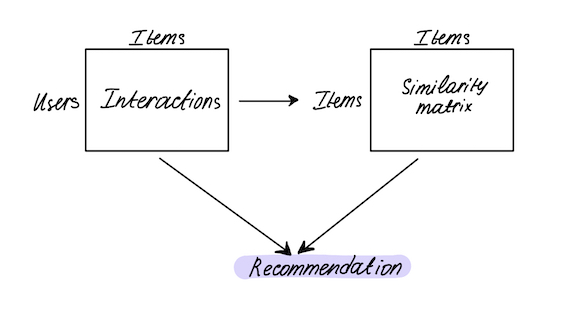

### Recommendations <a class="anchor" id="itemknn_rec"></a>
Consider an example of how to make a top-1 recommendation for one user. 

1. Suppose user interacted with items 2 and 4, which have weights 2 and 4, respectively
   
2. Calculate similarity matrix for each item, which includes 2 neighbors (for other items set similarity equal to 0). Resulting matrix stores information on item closeness
   
3. For recommendation use interaction values as weights and calculate how likely a user is to like an item. For instance, as the user has weight 2 for item 2, we can go through the closest items and add results to the respective item. Closest to item 2 is item 1, thus, add to item 1 the following: $2 \cdot 0.8 = 1.6$, add to item 4: $2 \cdot 0.5 = 1$
   
4. After all calculations are performed, sum the values for each item and recommend items with the greatest sum. Also, it is possible to filter out already seen recommendations by setting their value to 0.

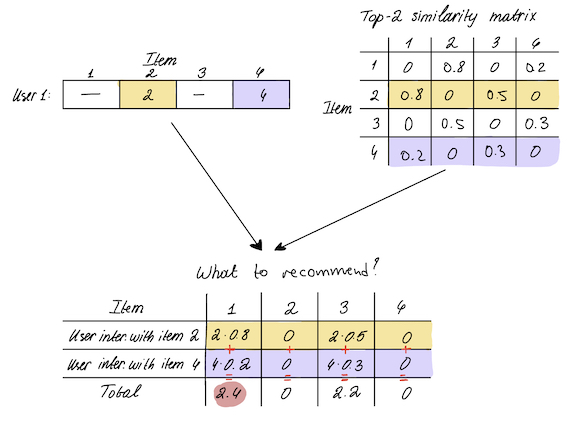

### RecTools implementation <a class="anchor" id="itemknn_impl"></a>
RecTools provides wrapper for implicit library ItemKNN models

### Model application <a class="anchor" id="itemknn_apply"></a>
* pass one of the base models: `implicit.nearest_neighbours.CosineRecommender`, `implicit.nearest_neighbours.TFIDFRecommender`, `implicit.nearest_neighbours.BM25Recommender`
* specify `K` for number of neighbours in item-item similarity matrix
* specify model params for `BM25Recommender`
* If we use dataset with features for `fit` and `recommend`, model just skips this info

In [27]:
%%time
model = ImplicitItemKNNWrapperModel(CosineRecommender(K=10))
model.fit(dataset);

CPU times: user 764 ms, sys: 32.2 ms, total: 797 ms
Wall time: 796 ms


In [28]:
recos = model.recommend(
    users=test_hot_users,
    dataset=dataset,
    k=3,
    filter_viewed=True,
)
recos.merge(items[["item_id", "title_orig"]], on="item_id")

,user_id,item_id,score,rank,title_orig
0,176549,11749,5.105861,1,Incredibles 2
1,176549,16270,4.125425,2,Coco
2,176549,11985,3.047437,3,Toy Story 4


### Links <a class="anchor" id="itemknn_links"></a>
1. implicit library itemKKN [documentation](https://benfred.github.io/implicit/api/models/cpu/knn.html)
2. Comparison of Cosine, TF-IDF and BM25 metrics for the algorithm: [Distance Metrics for Fun and Profit](https://www.benfrederickson.com/distance-metrics/)

# Linear Autoencoders <a class="anchor" id="la"></a>
Autoencoders in general attempt to make output of the model as close to input as possible. In recommendation setting there is a class of models that aim for the same task. Interactions matrix should be approximated as closely as possible based on the data that is present only in this matrix itself. Linear autoencoders like EASE and SLIM were found to be strong recommender baselines by many academy and industry practitioners.

## EASE <a class="anchor" id="ease"></a>

### Model description <a class="anchor" id="ease_desc"></a>
The model's goal is to find a dense item-item similarity matrix which will reconstruct the interactions matrix when being multiplied on it. Unlike neighborhood models, its computation is done by loss minimization. \
Matrix we would like to receive is B, it can be received from the following minimization problem:
$$ 
\begin{equation}
    \begin{cases}
    min_{B} \lVert X - XB \rVert _{F}^{2} + \lambda \cdot \lVert B \rvert\rvert  _{F}^{2} \\
    diag(B) = 0
    \end{cases}\,.
\end{equation}$$  
X - interactions matrix \
B - weight-matrix, which should be found \
$\lVert X - XB \rvert\rvert  _{F}$ - Frobenius norm \
$\lambda$ - regularization term to avoid overfitting \
Constraint is needed, as otherwise model may return identity B and because of the fact that replicating input model should generalize (not recommend the same item as input)

By analyzing closed-form solution it was found out that B can be calculated from the inverse of Gram matrix = $X \cdot X^{T}$. Thus, simple algorithm is used to find B.

Algorithm:

1. Define $G = X \cdot X^{T}$
   
2. Add $\lambda$ to diagonal indices of G
   
3. Find inverse of G ($G^{-1}$)
   
4. B = $\frac{G^{-1}}{diag(G^{-1})}$, where $diag(G^{-1})$ is array of diagonal elements
   
5. Set all elements on the diagonal of B equal to 0

### Recommendations <a class="anchor" id="ease_rec"></a>
Recommendations for one user are defined as following: 

1. Compute scores $s_{u} = x_{u} \cdot B$ where $x_{u}$ refers to user row in interactions matrix

2. Take k items with greatest scores

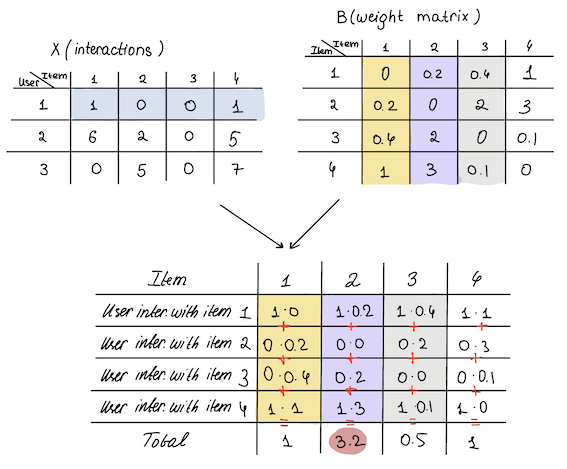

### Model application <a class="anchor" id="ease_apply"></a>
* `regularization` is the only hyper-parameter for the model
* This algorithm requires a lot of RAM during `fit` method. Out-of-memory issues are possible for big datasets. Reasonable catalog size for local development is about 30k items. Reasonable amount of interactions is about 20m.
* If we use dataset with features for `fit` and `recommend`, model just skips this info

In [29]:
%%time
model = EASEModel(regularization=500)
model.fit(dataset);

CPU times: user 3min 22s, sys: 2.13 s, total: 3min 25s
Wall time: 3min 25s


In [30]:
recos = model.recommend(
    users=test_hot_users,
    dataset=dataset,
    k=3,
    filter_viewed=True,
)
recos.merge(items[["item_id", "title_orig"]], on="item_id")

,user_id,item_id,score,rank,title_orig
0,176549,11749,1.545711,1,Incredibles 2
1,176549,334,1.422080,2,Brave
2,176549,8254,1.272578,3,Finding Nemo


### Links <a class="anchor" id="ease_links"></a>
1. EASE original paper: [Embarrassingly Shallow Autoencoders for Sparse Data](https://arxiv.org/abs/1905.03375)
2. **Proving EASE quality**: [Everyone’s a Winner! On Hyperparameter Tuning of Recommendation Models](https://dl.acm.org/doi/10.1145/3604915.3609488)
3. **Proving EASE quality**: [Top-N Recommendation Algorithms: A Quest for the State-of-the-Art](https://arxiv.org/abs/2203.01155)
4. **Proving EASE quality**: [Challenging the Myth of Graph Collaborative Filtering: a Reasoned and Reproducibility-driven Analysis](https://arxiv.org/abs/2308.00404)
5. **Proving linear autoencoders quality** (SLIM model): [Are We Really Making Much Progress? A Worrying Analysis of Recent Neural Recommendation Approaches](https://arxiv.org/abs/1907.06902)